# This notebook is intended to generate color images by stacking multi-band images

### import packages

In [59]:
from matplotlib import pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import sep
from scipy.ndimage import interpolation as interp
#from image_registration import chi2_shift
#from image_registration.fft_tools import shift
import glob

In [16]:
files = glob.glob('*fits')
filters = []
for file in files:
    _filter = pyfits.getheader(file)['FILTER']
    filters.append(_filter)
filters = np.array(filters)
files = np.array(files)
print ('All the filters we have: ', np.unique(filters))

All the filters we have:  ['B' 'R' 'V']


In [49]:
info = {}
for _filt in np.unique(filters):
    filt_filename = files[np.where(filters == _filt)[0]]
    info.update({_filt: filt_filename})
info

{'B': array(['M83_AP_6150365_B_000.fits', 'M83_AP_6150365_B_001.fits'],
       dtype='<U25'),
 'R': array(['M83_AP_6150365_R_002.fits'], dtype='<U25'),
 'V': array(['M83_AP_6150365_V_001.fits'], dtype='<U25')}

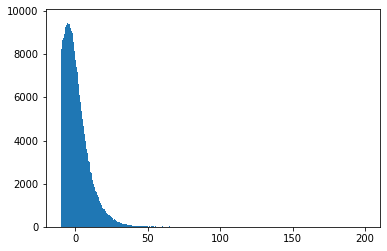

In [50]:
data = pyfits.getdata(info['B'][0])
image_hist = plt.hist(data.flatten(), bins=1000, range=(-10,200))

[-23.66993046  49.32633533]


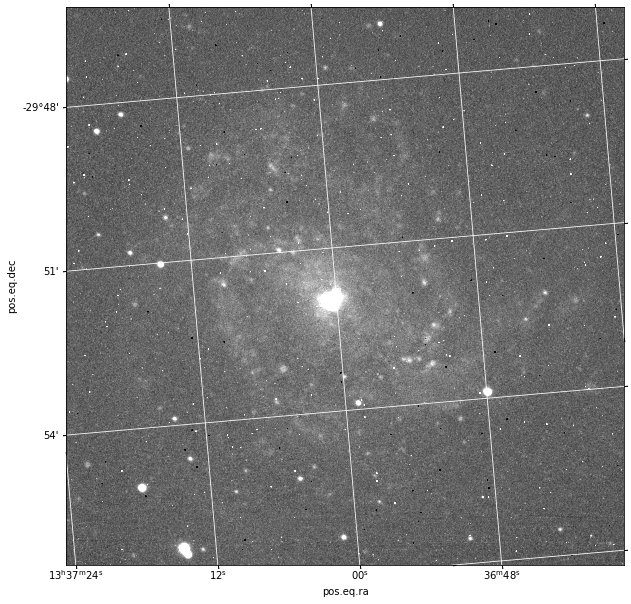

In [162]:
hdu = pyfits.open(info['B'][0])[0]
wcs = WCS(hdu.header)
fig= plt.figure(figsize=(10,12))
ax = plt.subplot(projection=wcs)
data = pyfits.getdata(info['B'][0])
#stack = (band_image['B']['data']+band_image['V']['data']+band_image['rp']['data'])
ax.imshow(data, origin='lower', cmap='gray', vmin=-40, vmax=50)#interpolation='nearest'
#or use np.quantile(data, [0.02, 0.98]) to the proper vmin and vmax
print(np.quantile(data, [0.02, 0.9965]))
ax.grid(color='white', ls='solid')

In [52]:
image_size = np.shape(data)
image_size

(1024, 1024)

In [122]:
def find_offset(ref_x, ref_y, _data):
    _data = _data.byteswap().newbyteorder()
    _data_bkg = sep.Background(_data)
    data_objs = sep.extract(_data, thresh=20.0, err=_data_bkg.globalrms, minarea=8)
    for i,j in enumerate(data_objs['x']):
        shift_x = ref_x - data_objs['x'][i]
        shift_y = ref_y - data_objs['y'][i]
        distance = np.sqrt((shift_x)**2+(shift_y)**2)
        if distance < 10:
            return shift_x, shift_y
            break

In [148]:
band_image = {}
shift_band_image = {}

ref_file = info[list(info.keys())[0]]
ref_img = pyfits.getdata(ref_file[0])
ref_img = ref_img.byteswap().newbyteorder() # magic command
ref_bkg = sep.Background(ref_img)
ref_objects = sep.extract(ref_img, thresh=20.0, err=ref_bkg.globalrms, minarea=10)

for band in info.keys():
    print('Stacking all images in filter: {}'.format(band))
    _data = np.zeros(image_size)
    _shift_data = np.zeros(image_size)
    for file in info[band]:
        print(file)
        tmp_data = pyfits.getdata(file)
        sx, sy = [], []
        for i,j in enumerate(ref_objects['x']):
            tmp_sx, tmp_sy = find_offset(ref_objects['x'][i], ref_objects['y'][i], tmp_data)
            sx.append(tmp_sx)
            sy.append(tmp_sy)

        shift_x, shift_y = np.mean(sx), np.mean(sy)

        print('Average offsets in x: {}, y: {}\n'.format(round(shift_x, 3), round(shift_y, 3)))
        new_data = interp.shift(tmp_data, [shift_y, shift_x])
        _shift_data += new_data
        _data += tmp_data
    
    band_image.update({band: _data/float(len(info[band]))})
    shift_band_image.update({band: _shift_data/float(len(info[band]))})

Stacking all images in filter: B
M83_AP_6150365_B_000.fits
Average offsets in x: 0.0, y: 0.0

M83_AP_6150365_B_001.fits
Average offsets in x: 0.0, y: 0.0

Stacking all images in filter: R
M83_AP_6150365_R_002.fits
Average offsets in x: 6.918, y: -0.833

Stacking all images in filter: V
M83_AP_6150365_V_001.fits
Average offsets in x: 2.734, y: -0.113



/Users/crisp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


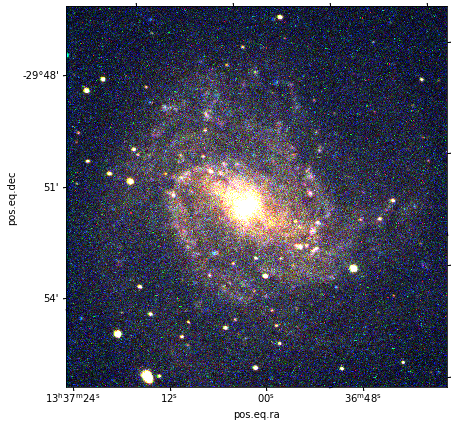

In [153]:
hdu = pyfits.open(info['B'][0])[0]
wcs = WCS(hdu.header)
bands = ['R', 'V', 'B'] #in order RGB
scale_factor = np.array([1, 0.9, 1.0])*1.
size = 1024
simpleRGB = []
simpleRGB=np.zeros((size,size,3),dtype=float)


for i in range(len(bands)):
    #data = band_image[bands[i]].copy()
    data = shift_band_image[bands[i]].copy()
    min_value = np.quantile(data, [0.02, 1-0.02])[0]
    max_value = np.quantile(data, [0.02, 1-0.02])[1]
    data = (data - min_value)/(max_value-min_value)
    simpleRGB[:,:,i]=(data*scale_factor[i])**1.5

fig= plt.figure(figsize=(8,7))
ax = plt.subplot(projection=wcs)
img = ax.imshow(simpleRGB, origin='lower', interpolation='nearest')#interpolation='nearest'
#plt.plot(objects['x'],objects['y'],'xr')